In [1]:
import numpy as np
from src.monte_carlo import monte_carlo_mix, Scroll, strategy_fixed_sequence, stop_all_success, stop_atk_at_least, Item

In [2]:
%load_ext autoreload
%autoreload 2

## 14g 手套

In [3]:
WEAPON_SCROLL_PRICE = {"A": 269, "B": 6.4, "C": 4800, "D": 9.5}
SHIELD_SCROLL_PRICE = {"A": 79, "B": 2000, "C": 1522, "D": 700}
WEAPON_SWORD = {"108": 25000, "107": 15000}

In [4]:
mxb_to_rmb = 56 # 56W mxb = 1rmb
GROVE_ATTACK_PRICE = {
    "10": 1500,
    "11": 2500,
    "12": 5000,
    "13": 14000,
    "14": 41000,
    "15": 2200*mxb_to_rmb,
    "16": 6000*mxb_to_rmb,
    "17": 12500*mxb_to_rmb
}

GROVE_SCROLL_PRICE = {
    "A": 33, 
    "B": 597, 
    "C": 14959, 
    "D": 2325
}
item_price = 2500

SCROLL_A = Scroll("A_10p_+3", success_p=0.11, atk_value=3, destroy_on_fail_p=0.0)
SCROLL_B = Scroll("B_60p_+2", success_p=0.66, atk_value=2, destroy_on_fail_p=0.0)
SCROLL_C = Scroll("C_30p_+3_boom50", success_p=0.33, atk_value=3, destroy_on_fail_p=0.50)
SCROLL_D = Scroll("D_70p_+2_boom50", success_p=0.77, atk_value=2, destroy_on_fail_p=0.50)

SCROLL_SET = {"A": SCROLL_A, "B": SCROLL_B, "C": SCROLL_C, "D": SCROLL_D}
NAME_TO_KEY = {SCROLL_A.name: "A", SCROLL_B.name: "B", SCROLL_C.name: "C", SCROLL_D.name: "D"}  # 便于反查类型键

In [5]:
from typing import Callable
def stop_all_success() -> Callable[[Item], bool]:
    # 目标：在不爆装情况下，全成功
    def cond(state: Item) -> bool:
        return (np.sum(state.results_history) == state.num_slots) and (not state.destroyed)
    return cond

def stop_no_destroyed() -> Callable[[Item], bool]:
    # 目标：在不爆装情况下，全成功
    def cond(state: Item) -> bool:
        return not state.destroyed
    return cond

In [ ]:
import time
seed = int(time.time())
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
trials = 20000

target = stop_all_success()

scroll_list = ["D", "D", "D", "D", "D", "D", "D"]
strat1 = strategy_fixed_sequence(scroll_list, SCROLL_SET)

item_state = Item("BrownGrove", num_slots=7)
results = monte_carlo_mix(rng, trials, item_state, strat1, target, stop_on_first_fail=True, properties=["atk_value"])

grove_cost = np.mean(results['scrolls_distribution']['D_70p_+2_boom50']) * GROVE_SCROLL_PRICE["D"]
scrolls_cost = np.mean(results['items_distribution']) * item_price 

v,c = np.unique(results['items_properties']['atk_value']['good'], return_counts=True)
grove_sell = 0
for v_i,c_i in zip(v,c):
    if v_i < 14:
        if str(v_i) in GROVE_ATTACK_PRICE.keys():
            print(v_i, c_i)
            grove_sell += GROVE_ATTACK_PRICE[str(v_i)]*c_i
grove_sell /= trials

print(f"total cost: {(grove_cost+scrolls_cost-grove_sell):.2f}")
print(f"grove cost: {grove_cost:.2f}, scrolls_cost: {scrolls_cost:.2f}, grove_sell: {grove_sell:.2f}")

1758174544


Monte Carlo: 100%|██████████| 20000/20000 [00:03<00:00, 6565.73it/s]


10 3946
12 3103
total cost: 68430.36
grove cost: 53656.93, scrolls_cost: 15845.12, grove_sell: 1071.70


In [7]:
import matplotlib.pyplot as plt
from src.plot import create_figure

def plot_bar_int(data, ax=None):
    values, counts = np.unique(data, return_counts=True)
    if ax is None:
        plt.bar(values, counts, width=0.9, align='center', edgecolor='k')
        plt.xticks(values)  # 每个整数一个刻度
    else:
        ax.bar(values, counts, width=0.9, align='center', edgecolor='k')
        ax.set_xticks(values)  # 每个整数一个刻度

def plot_cdf_pdf(data, fig_title):

    num_items = []
    probability = []
    for i in range(0,np.max(data)+1):
        probability.append(np.sum(np.array(data) < i+1) / len(data))
        num_items.append(i+1)

    valid_num_items = range(0, int(np.mean(data) + 3*np.std(data, ddof=1)))
    valid_probability = np.array(probability)[valid_num_items]

    fig, axs = create_figure(1,3)
    fig.suptitle(fig_title)
    ax1 = fig.add_subplot(axs[0])
    ax1.plot(valid_probability)
    ax1.set_title("CDF")

    ax2 = fig.add_subplot(axs[1])
    ax2.hist(data, bins=np.arange(0,np.max(data),5))
    ax2.axvline(np.max(valid_num_items), color='r')
    ax2.set_title("PDF")

    ax3 = fig.add_subplot(axs[2])
    ax3.plot(np.diff(valid_probability))

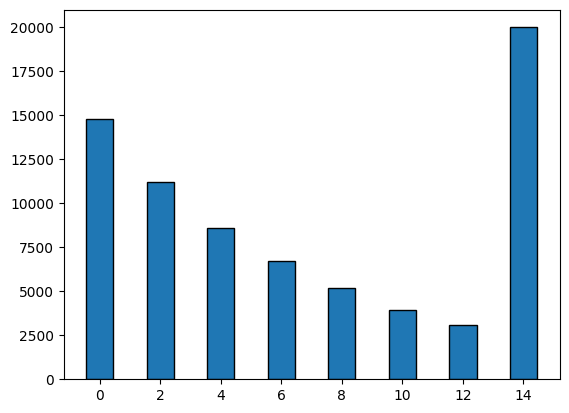

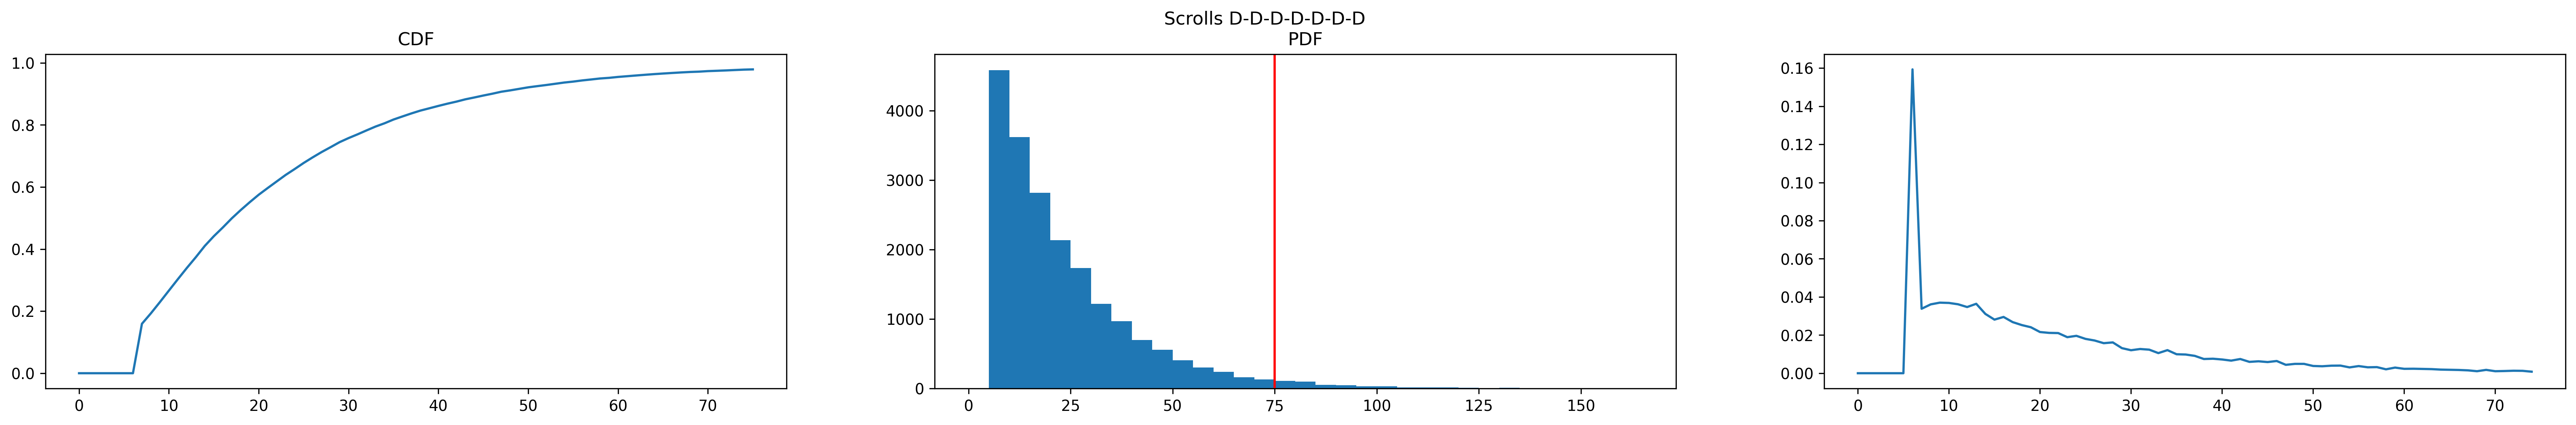

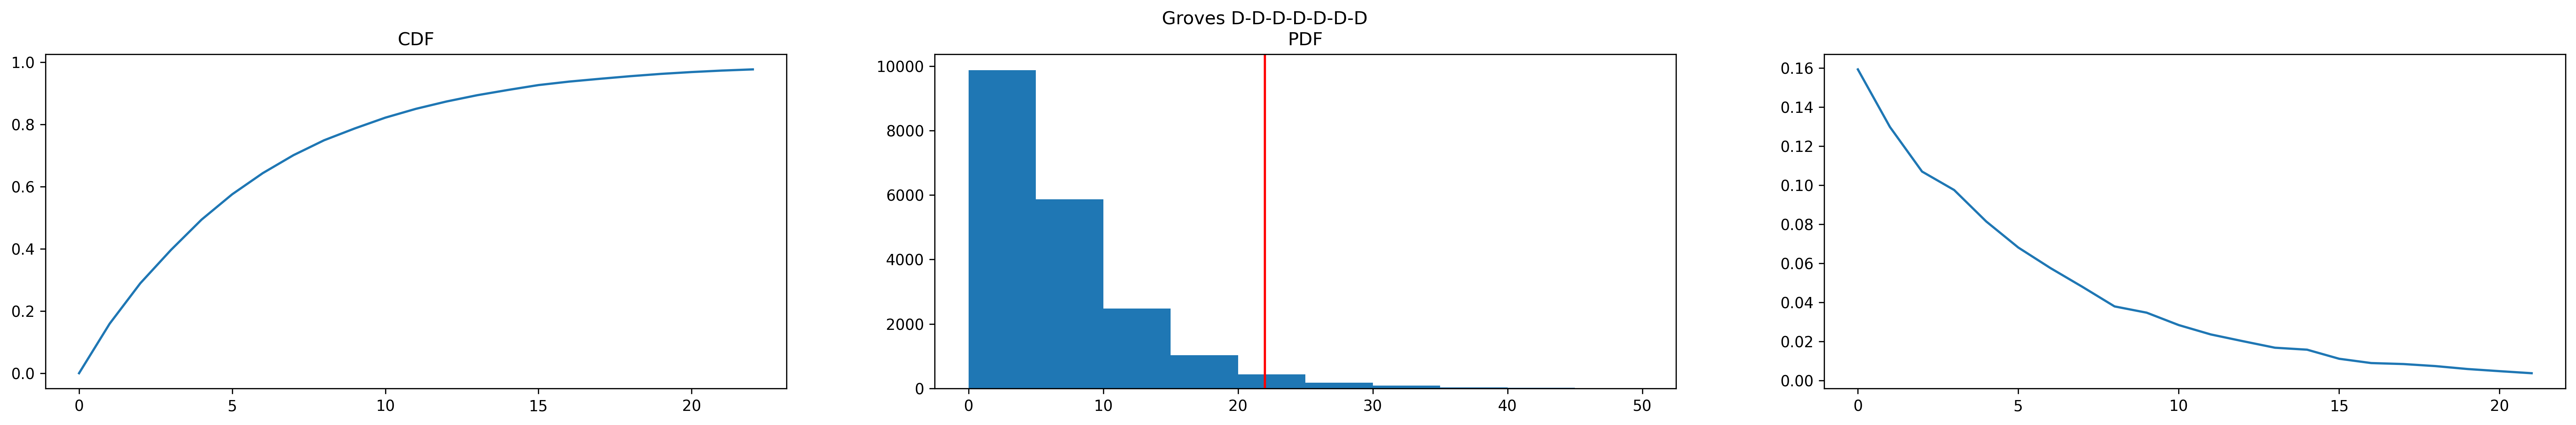

In [10]:
data = results['items_properties']['atk_value']['good']
plot_bar_int(data)

data = results['scrolls_distribution']['D_70p_+2_boom50']
plot_cdf_pdf(data, "Scrolls D-D-D-D-D-D-D")

plot_cdf_pdf(results['items_distribution'], "Groves D-D-D-D-D-D-D")